In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pymc3 as pm
from pymc3.ode import DifferentialEquation
print('Running on PyMC3 v{}'.format(pm.__version__))

#from bs4 import BeautifulSoup
#import requests
#import re

import os

import joblib 

import pandas as pd

import theano
import scipy
floatX = theano.config.floatX

Running on PyMC3 v3.8


In [3]:
test = 'Canada British Columbia'
test[7:]

'British Columbia'

In [4]:
country = 'Canada'
file = os.path.join('csv_out',country+'.csv')
country_df = pd.read_csv(file)
country_df

def get_country_sir(country, start_date='', end_date='', min_cases=10):
    
    # update for any country
    # italy
    population = 60e6
    
    # get population - only for canada for now
    pop_df = pd.read_csv(os.path.join('data', 'pop_canada.csv'))
    
    province = ''
    if country.lower()!= 'canada':
        province = country[7:]
    else:
        province = 'Canada'
        
    if province in pop_df['Geography'].values:
        idx = pop_df[pop_df['Geography']==province].index
        population = pop_df.iloc[idx, -1].values[0]
    else:
        population = 1000000
        population = 60e6
        
    if type(population)==str:
        population = population.replace(',', '')
        population = int(population)
        
    #print(population)
    
    country = country.title().replace(' ', '_')
    file = os.path.join('csv_out',country+'.csv')
    country_df = pd.read_csv(file)
    
    start = country_df[country_df.Date == start_date].index
    if len(start)==0:
        start = 0
    else:
        start = start[0]
        
    end = country_df[country_df.Date == end_date].index
    if len(end)==0:
        end = country_df.index[-1]
    else:
        end = end[0]
        
    dates = country_df.loc[start:end + 1, 'Date'].values
    data = country_df.loc[start:end + 1, 'Confirmed'].values
    deaths = country_df.loc[start:end + 1, 'Deaths'].values
    recovered = country_df.loc[start:end+1, 'Recovered'].values

    if max(data) < min_cases:
        print('Warning, {:d} cases has not occured in this date range.')
    else:
        min_start = np.where(np.array(data) >= min_cases)[0][0]
        data = data[min_start:]
        dates = dates[min_start:]
        deaths = deaths[min_start:]
        recovered = recovered[min_start:]
        
    # infected = total cases - deaths - recoveries
    infected = data - deaths - recovered
    
    # susceptible = population - infected - deaths - recovered
    susceptible = population - infected - deaths - recovered
        

    return dates, np.arange(0, len(data)), susceptible/population, infected/population
    
    

In [74]:
get_country_sir('Canada British Columbia')

5110917


(array(['3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
        '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20',
        '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
        '3/22/20', '3/23/20'], dtype=object),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([0.99999765, 0.99999746, 0.99999589, 0.99999589, 0.99999472,
        0.99999374, 0.99999374, 0.99999237, 0.999991  , 0.99998748,
        0.99998748, 0.99998572, 0.99997985, 0.99997985, 0.99996361,
        0.9999548 , 0.99994698, 0.99991704, 0.99991704, 0.99991704]),
 array([1.76093644e-06, 1.95659605e-06, 3.52187289e-06, 3.32621328e-06,
        4.50017091e-06, 5.28280933e-06, 5.28280933e-06, 6.65242656e-06,
        8.02204379e-06, 1.15439167e-05, 1.15439167e-05, 1.33048531e-05,
        1.85876624e-05, 1.85876624e-05, 3.42404308e-05, 4.30451130e-05,
        5.06758376e-05, 8.02204379e-05, 8.02204379e-05, 8.02204379e-05]))

In [5]:
dates, x, sus, inf = get_country_sir('Canada British Columbia', min_cases=100)
# sus and inf are already normalized
# just normalize x
x_train = x[:-3]
x_test = x[-3:]

scalex = MinMaxScaler()
x_scale = scalex.fit_transform(x_train.reshape(-1,1)).flatten()

sus_train = sus[:-3]
sus_test = sus[-3:]

inf_train = inf[:-3]
inf_test = inf[-3:]

# make single array
y_train = np.hstack((sus_train.reshape(-1,1), inf_train.reshape(-1,1)))
y_test = np.hstack((sus_test.reshape(-1,1), inf_test.reshape(-1,1)))

y_train.shape

y0 = [y_train[0][0], y_train[0][1]]

In [6]:
class DE(pm.ode.DifferentialEquation):
    def _simulate(self, y0, theta):
        # Initial condition comprised of state initial conditions and raveled sensitivity matrix
        s0 = np.concatenate([y0, self._sens_ic])
        
        # perform the integration
        sol = scipy.integrate.solve_ivp(
            fun = lambda t, Y: self._system(Y, t, tuple(np.concatenate([y0, theta]))),
            t_span=[self._augmented_times.min(), self._augmented_times.max()],
            y0=s0,
            method='RK23',
            t_eval=self._augmented_times[1:],
            atol=1, rtol=1,
            max_step=0.02).y.T.astype(floatX)
        
        # The solution
        y = sol[:, :self.n_states]

        # The sensitivities, reshaped to be a sequence of matrices
        sens = sol[0:, self.n_states:].reshape(self.n_times, self.n_states, self.n_p)

        return y, sens

In [121]:
def sir_function(y, t, p):
    # 'constants'
    beta = p[0] #rename to delta when testing
    lmbda = p[1]
    #beta = p[2]*pm.math.exp(-t*delta)
    
    # y = (s, i)
    
    # susceptible differential
    ds = -y[0]*y[1]*beta
    
    # infected differential
    di = y[0]*y[1]*beta - y[1]*lmbda
    
    return [ds, di]


sir_model = DE(
    func=sir_function,
    times=x_train,
    n_states=2, # number of y (sus and inf)
    n_theta=2, # number of parameters (lambda, delta, beta_0)
    t0=0
)

In [ ]:
with pm.Model() as model4:
    
    print('Initializing Priors')
    sigma = pm.HalfNormal('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lmbda = pm.Normal('lambda', 0, 10)
    delta = pm.Normal('delta', 0, 10)
    beta = pm.Deterministic('beta', lmbda*R0)
    
    
    print('Setting up model')
    sir_curves = sir_model(y0=y0, theta=[beta, lmbda])#[delta, lmbda, beta])

    Y = pm.Normal('Y', mu=sir_curves, sigma=sigma, observed=y_train)

    print('Starting sampling')
    #prior = pm.sample_prior_predictive(progressbar=True)
    trace = pm.sample(2000, 
                      tune=1000, 
                      #target_accept=0.9, 
                      cores=4, 
                      progressbar=True)
    posterior_predictive = pm.sample_posterior_predictive(trace, progressbar=True)

    #data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Initializing Priors
Setting up model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Starting sampling


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, lambda, R0, sigma]


In [21]:
a = posterior_predictive['Y']
y0 = a[:,:,0]
y1 = a[:,:,1]

y0_mean = np.mean(y0, axis=0)
y1_mean = np.mean(y1, axis=0)

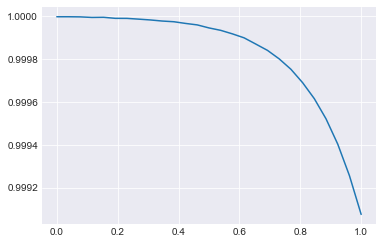

In [23]:
plt.plot(x_scale, y0_mean)


In [13]:
x_train.shape

(27,)

In [6]:
def sir_function(y, t, p):
    # 'constants'
    #delta = p[0]  # rename to delta when testing
    beta = p[0]
    lmbda = p[1]
    #beta = p[2]*pm.math.exp(-t*delta)

    # y = (s, i)

    # susceptible differential
    ds = -y[0] * y[1] * beta

    # infected differential
    di = y[0] * y[1] * beta - y[1] * lmbda

    return [ds, di]


def sir_model(x, y, y0):

    x = np.asarray(x).flatten()
    y = np.asarray(y)

    sir_ode = DifferentialEquation(
        func=sir_function,
        times=x,
        n_states=2,  # number of y (sus and inf)
        n_theta=2,  # number of parameters (lambda, delta, beta_0)
        t0=0
    )

    with pm.Model() as model:

        # Overall model uncertainty
        sigma = pm.HalfNormal('sigma', 3, shape=2)

        # R0 is bounded below by 1 because we see an epidemic has occured
        R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3)
        # R0 = pm.Normal('R0', 2, 2)

        # approximate lmbda as 1/9 to begin (between 1/5 and 1/13 ish)
        lmbda = pm.Normal('lambda', 1/9, 0.1)

        # allow delta to be whatever, but near 0
        # delta = pm.Normal('delta', 0, 1)
        beta = pm.Deterministic('beta', lmbda * R0)

        # print('Setting up model')
        sir_curves = sir_ode(y0=y0, theta=[beta, lmbda])  # [delta, lmbda, beta])

        y_obs = pm.Normal('y_obs', mu=sir_curves, sigma=sigma, observed=y)

    return model

In [7]:
# load from save to check out

def predict_model_from_file(model, trace_path, samples):
    with model:
        trace = pm.load_trace(directory=trace_path)
        y_hat = pm.sample_posterior_predictive(trace[500:], samples=samples, progressbar=False)

    return y_hat['y_obs'], trace

def sir_bayes_plot(country, num_days):
    #country = 'Canada British Columbia'
    dates, x, sus, inf = get_country_sir(country, min_cases=1)
    tr_path = os.path.join('traces', country.lower().replace(' ','_'))
    # sus and inf are already normalized
    # just normalize x
    x_train = x[:-1]
    x_test = x[-1:]

    sus_train = sus[:-1]
    sus_test = sus[-1:]

    inf_train = inf[:-1]
    inf_test = inf[-1:]

    # make single array
    y_train = np.hstack((sus_train.reshape(-1, 1), inf_train.reshape(-1, 1)))
    y_test = np.hstack((sus_test.reshape(-1, 1), inf_test.reshape(-1, 1)))

    y_train.shape

    y0 = [y_train[0][0], y_train[0][1]]


    last = len(x)
    extend = np.arange(last, last+num_days)
    x_updated = np.append(x, extend)
    y_updated = np.empty((x_updated.shape[0], y_train.shape[1]))

    sir = sir_model(x_updated, y_updated, y0)
    posterior_predictive, trace = predict_model_from_file(sir, os.path.join(tr_path, 'sir'), 1000)
    
    
    all_y = posterior_predictive
    y0_array = all_y[:, :, 0]
    y1_array = all_y[:, :, 1]
    y2_array = 1 -y0_array - y1_array
    total_cases = y1_array + y2_array
    new_cases  = np.gradient(total_cases, axis = 1)
    
    y0_mean = np.mean(y0_array, axis=0)
    y0_std = 2*np.std(y0_array, axis=0)

    y1_mean = np.mean(y1_array, axis=0)
    y1_std = 2*np.std(y1_array, axis=0)

    y2_mean = np.mean(y2_array, axis=0)
    y2_std = 2*np.std(y2_array, axis=0)

    total_cases_mean = np.mean(total_cases, axis=0)
    total_cases_std = 2*np.std(total_cases, axis=0)

    new_cases_mean = np.mean(new_cases, axis=0)
    new_cases_std = 2*np.std(new_cases, axis=0)
    
    # SIR Curves 
    fig, ax = plt.subplots(1, 3, figsize=(20,8))
    
    plt.sca(ax[0])
    plt.fill_between(x_updated, y0_mean+y0_std, y0_mean-y0_std, alpha=0.5, color='g')
    plt.plot(x_train, sus_train, c='g', label='suseptible')
    plt.scatter(x_test, sus_test, color = 'g')
    plt.plot(x_updated, y0_mean, '--g', alpha=0.7)

    plt.fill_between(x_updated, y1_mean+y1_std, y1_mean-y1_std, alpha=0.5, color='r')
    plt.plot(x_train, inf_train, c='r', label='infected')
    plt.scatter(x_test, inf_test, color = 'r')
    plt.plot(x_updated, y1_mean, '--r', alpha=0.7)

    plt.fill_between(x_updated, y2_mean+y2_std, y2_mean-y2_std, alpha=0.5, color='b')
    plt.plot(x_train, 1-sus_train-inf_train, c='b', label='resistant')
    plt.scatter(x_test, 1-sus_test-inf_test, color = 'b')
    plt.plot(x_updated, y2_mean, '--b', alpha=0.7)
    
    plt.xlabel('Days')
    plt.ylim([0, 1.01])
    plt.xlim([x_updated[0], x_updated[-1]])
    plt.title('Infection Rates')
    plt.legend()


    # Total Cases
    
    plt.sca(ax[1])
    plt.plot(x_updated, total_cases_mean, '--')
    plt.fill_between(x_updated, total_cases_mean+total_cases_std, total_cases_mean-total_cases_std)
    plt.xlabel('Days')
    plt.title('Total Cases')
    plt.ylim([0, 1.01])
    plt.xlim([x_updated[0], x_updated[-1]])


    # New Cases
    plt.sca(ax[2])
    plt.plot(x_updated, new_cases_mean, '--')
    plt.fill_between(x_updated, new_cases_mean+new_cases_std, new_cases_mean-new_cases_std)
    plt.xlabel('Days')
    plt.title('Number of New DAILY Cases')
    #plt.ylim([0, 0.1])
    plt.xlim([x_updated[0], x_updated[-1]])
    plt.show()
    
    # Parameters
    pm.plot_posterior(trace[:500])
    plt.show()

C:\Users\linds\Anaconda3\envs\pymc3\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


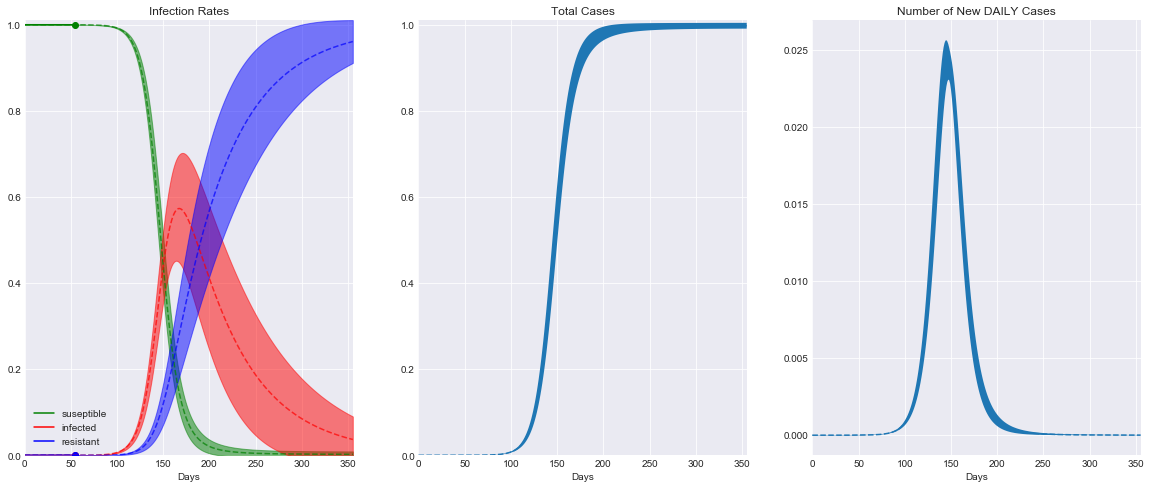

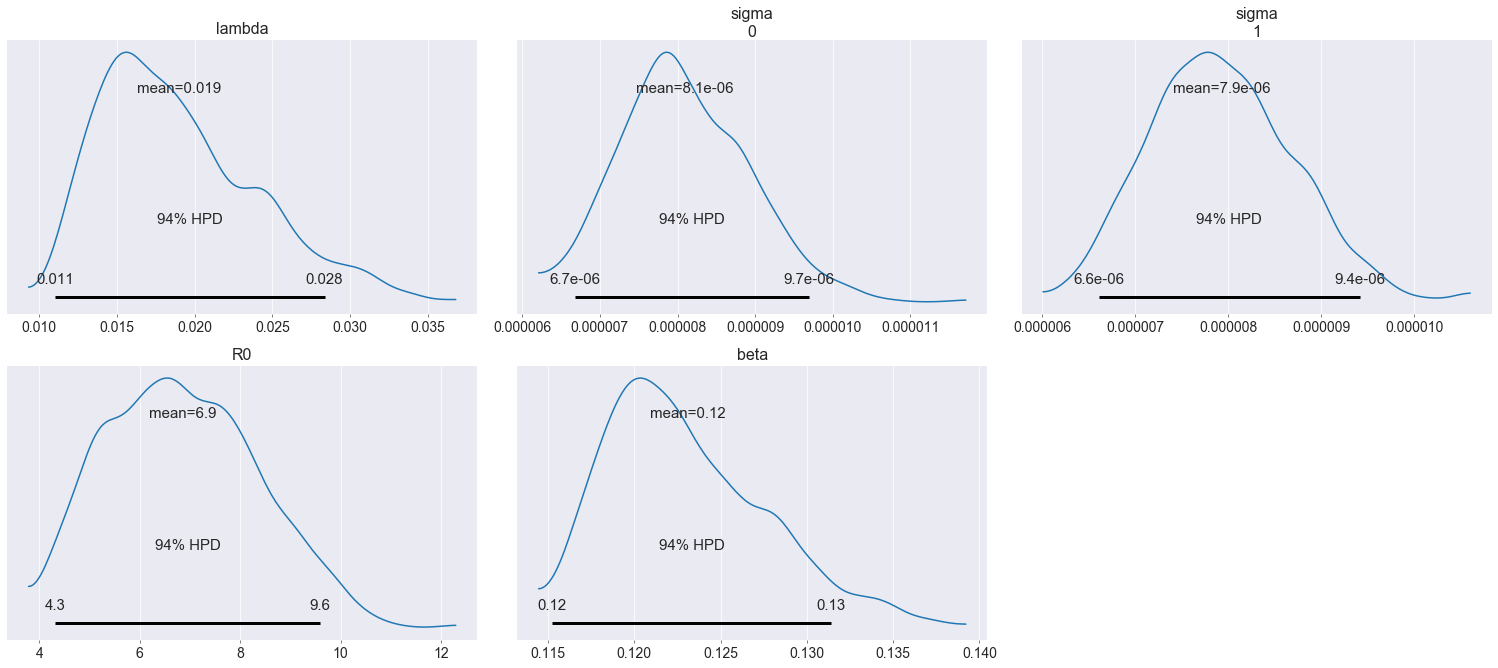

In [173]:
sir_bayes_plot('Canada British Columbia', 300)

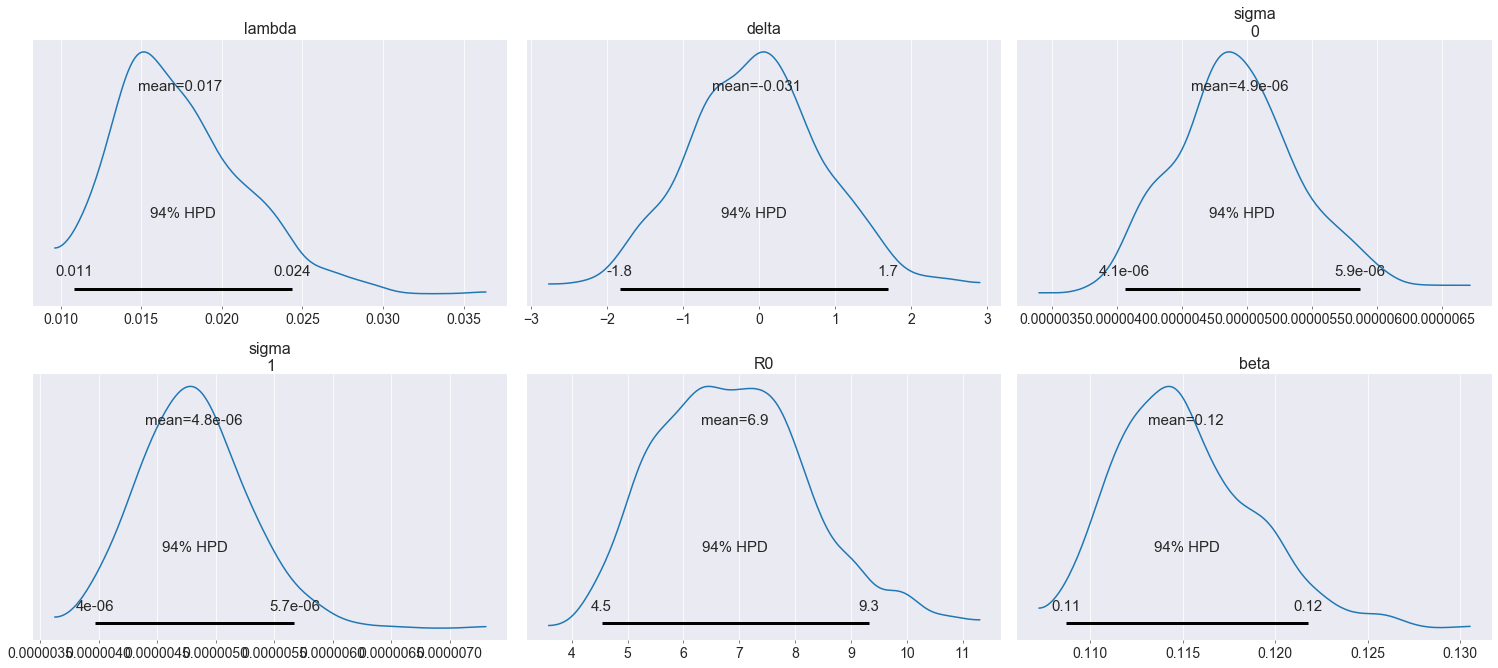

In [168]:
pm.plot_posterior(trace[:500])
plt.show()

In [14]:
country = 'Canada British Columbia'
num_days = 300
tr_path = os.path.join('traces', country.lower().replace(' ', '_'))
trace_path = os.path.join(tr_path, 'sir')

dates = joblib.load(os.path.join(tr_path, 'dates.pkl'))
x = joblib.load(os.path.join(tr_path, 'x_sir.pkl'))
sus = joblib.load(os.path.join(tr_path, 'sus_sir.pkl'))
inf = joblib.load(os.path.join(tr_path, 'inf_sir.pkl'))

# sus and inf are already normalized
# just normalize x
x_train = x[:-1]
x_test = x[-1:]

sus_train = sus[:-1]
sus_test = sus[-1:]

inf_train = inf[:-1]
inf_test = inf[-1:]

# make single array
y_train = np.hstack((sus_train.reshape(-1, 1), inf_train.reshape(-1, 1)))
y_test = np.hstack((sus_test.reshape(-1, 1), inf_test.reshape(-1, 1)))

y_train.shape

y0 = [y_train[0][0], y_train[0][1]]


last = len(x)
extend = np.arange(last, last+num_days)
x_updated = np.append(x, extend)
y_updated = np.empty((x_updated.shape[0], y_train.shape[1]))

sir = sir_model(x_updated, y_updated, y0)
with sir:
    trace = pm.load_trace(directory=trace_path)
    y_hat = pm.sample_posterior_predictive(trace[500:], samples=1000, progressbar=True)


C:\Users\linds\Anaconda3\envs\pymc3v2\lib\site-packages\pymc3\sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.70it/s]


In [17]:
trace.beta

array([0.11913113, 0.1243305 , 0.12447546, ..., 0.1240441 , 0.12419517,
       0.12119984])

In [147]:
stats = pm.summary(trace[:500])
delta = [stats.loc['delta', 'mean'], stats.loc['delta', 'sd']]
R0 = [stats.loc['R0', 'mean'], stats.loc['R0', 'sd']]
gamma = [stats.loc['lambda', 'mean'], stats.loc['lambda', 'sd']]

In [148]:
print('delta: {:0.3f} +/- {:0.3f}'.format(*delta))

delta: -0.031 +/- 0.951


In [19]:
all_y = y_hat['y_obs']# posterior_predictive['Y']
y0_array = all_y[:, :, 0]
y1_array = all_y[:, :, 1]
y2_array = 1 -y0_array - y1_array
total_cases = y1_array + y2_array
new_cases  = np.gradient(total_cases, axis = 1)

In [20]:
y0_mean = np.mean(y0_array, axis=0)
y0_std = 2*np.std(y0_array, axis=0)

y1_mean = np.mean(y1_array, axis=0)
y1_std = 2*np.std(y1_array, axis=0)

y2_mean = np.mean(y2_array, axis=0)
y2_std = 2*np.std(y2_array, axis=0)

total_cases_mean = np.mean(total_cases, axis=0)
total_cases_std = 2*np.std(total_cases, axis=0)

new_cases_mean = np.mean(new_cases, axis=0)
new_cases_std = 2*np.std(new_cases, axis=0)

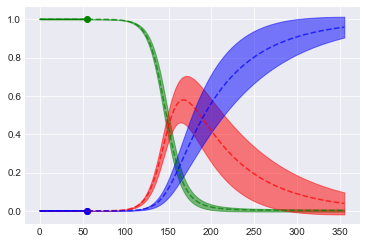

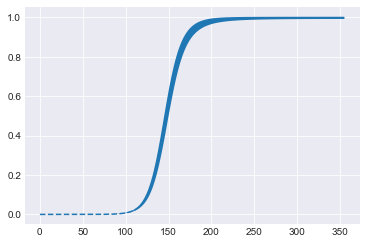

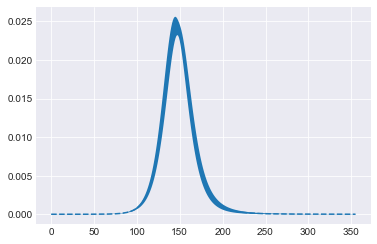

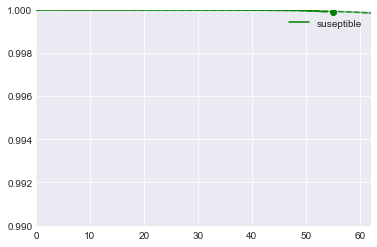

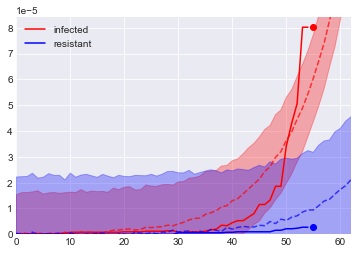

In [23]:
# SIR Curves 
fig, ax = plt.subplots()
ax.fill_between(x_updated, y0_mean+y0_std, y0_mean-y0_std, alpha=0.5, color='g')
ax.plot(x_train, sus_train, c='g', label='suseptible')
plt.scatter(x_test, sus_test, color = 'g')
ax.plot(x_updated, y0_mean, '--g', alpha=0.7)
handles, labels = ax.get_legend_handles_labels()
#plt.legend()
# ax2 = ax.twinx()

ax.fill_between(x_updated, y1_mean+y1_std, y1_mean-y1_std, alpha=0.5, color='r')
ax.plot(x_train, inf_train, c='r', label='infected')
ax.scatter(x_test, inf_test, color = 'r')
ax.plot(x_updated, y1_mean, '--r', alpha=0.7)


ax.fill_between(x_updated, y2_mean+y2_std, y2_mean-y2_std, alpha=0.5, color='b')
ax.plot(x_train, 1-sus_train-inf_train, c='b', label='resistant')
ax.scatter(x_test, 1-sus_test-inf_test, color = 'b')
ax.plot(x_updated, y2_mean, '--b', alpha=0.7)
#plt.legend()
#handles1, labels2 = ax2.get_legend_handles_labels()
#plt.yscale('log')
#plt.legend(handles = handles+handles1, labels=labels+labels2)
plt.show()

# Total Cases
plt.plot(x_updated, total_cases_mean, '--')
plt.fill_between(x_updated, total_cases_mean+total_cases_std, total_cases_mean-total_cases_std)
plt.show()

# New Cases
plt.plot(x_updated, new_cases_mean, '--')
plt.fill_between(x_updated, new_cases_mean+new_cases_std, new_cases_mean-new_cases_std)
plt.show()


# insets
fig, ax = plt.subplots()
plt.fill_between(x_updated, y0_mean+y0_std, y0_mean-y0_std, alpha=0.3, color='g')
plt.scatter(x_test, sus_test, color = 'g')
plt.plot(x_train, sus_train, c='g', label='suseptible')
plt.plot(x_updated, y0_mean, '--g', alpha=0.7)
plt.legend()
plt.xlim([0, x_test[-1]+7])
plt.ylim([np.min(sus)-0.01*np.min(sus), 1])
plt.show()


fig, ax2 = plt.subplots()
ax2.fill_between(x_updated, y1_mean+y1_std, y1_mean-y1_std, alpha=0.3, color='r')
ax2.scatter(x_test, inf_test, color = 'r')
ax2.plot(x_train, inf_train, c='r', label='infected')
ax2.plot(x_updated, y1_mean, '--r', alpha=0.7)

ax2.fill_between(x_updated, y2_mean+y2_std, y2_mean-y2_std, alpha=0.3, color='b')
ax2.scatter(x_test, 1-sus_test-inf_test, color = 'b')
ax2.plot(x_train, 1-sus_train-inf_train, c='b', label='resistant')
ax2.plot(x_updated, y2_mean, '--b', alpha=0.7)
plt.ylim([0, np.max(np.append(inf,1-inf-sus))+0.05*np.max(np.append(inf,1-inf-sus))])
handles1, labels2 = ax2.get_legend_handles_labels()
plt.legend()#handles = handles+handles1, labels=labels+labels2, loc = 'upper left')
plt.xlim([0, x_test[-1]+7])

plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000227E6A7A340>,
      dtype=object)

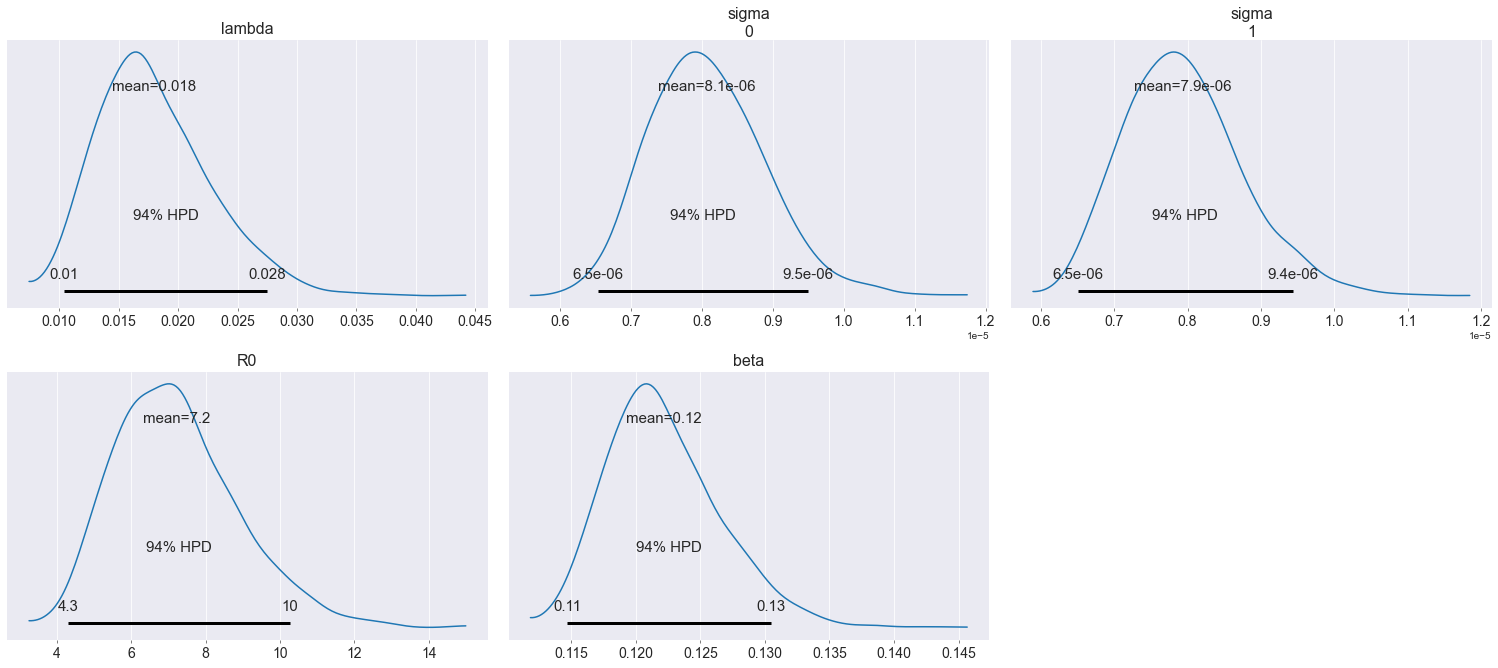

In [18]:
pm.plot_posterior(trace)

In [91]:
inf_test

array([0.00071135, 0.0007773 , 0.0007773 ])